In [3]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import pickle
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import pylab as plt

import DDPG
import torch

## Helper Functions

In [4]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)    

In [5]:
def run(env, agent, n_episodes=100, noise=0):
    rewards = []
    observations = []
    actions = []
    for ep in range(1, n_episodes+1):
        ep_reward = 0
        state, _info = env.reset()
        for t in range(2000):
            action = agent.act(state, noise)
            state, reward, done, _trunc, _info = env.step(action)
            observations.append(state)
            actions.append(action)
            ep_reward += reward
            if done or _trunc:
                break
        rewards.append(ep_reward)
        ep_reward = 0
    print(f'Mean reward: {np.mean(rewards)}')
    observations = np.asarray(observations)
    actions = np.asarray(actions)
    return observations, actions, rewards

# DDPG

In [6]:
env_name = "Pendulum-v1"

eps=0.1
ts=32
lr=0.0001
s=1

with open(f"./results/DDPG_{env_name}-eps{eps}-t{ts}-l{lr}-s{s}-stat.pkl", 'rb') as f:
    data = pickle.load(f)
    rewards = np.asarray(data["rewards"])
    losses =  np.asarray(data["losses"])

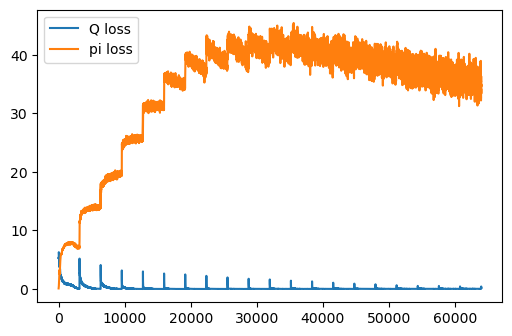

In [7]:
fig=plt.figure(figsize=(6,3.8))
plt.plot(running_mean(losses[:,0],10),label=f"Q loss")
plt.plot(running_mean(losses[:,1],10),label=f"pi loss")
plt.legend()

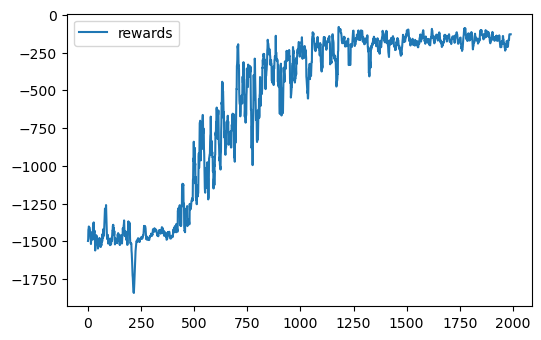

In [8]:
fig=plt.figure(figsize=(6,3.8))
plt.plot(running_mean(rewards,10),label=f"rewards")
plt.legend()

### Exploration Noise dependency

In [9]:
rewards = {}
lr = 0.0001
eps=[0.1,0.3,0.5]
ts=32
seed=1

for e in eps:
    with open(f"./results/DDPG_{env_name}-eps{e}-t{ts}-l{lr}-s{seed}-stat.pkl", 'rb') as f:
        data = pickle.load(f)
        rewards[e] = data["rewards"]

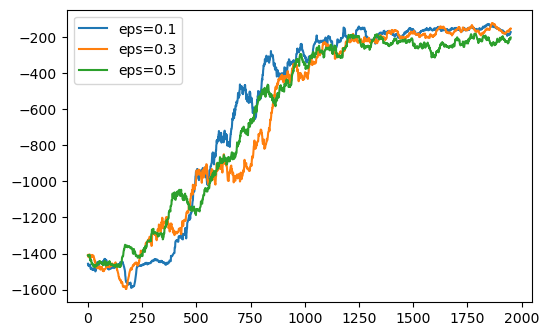

In [10]:
fig=plt.figure(figsize=(6,3.8))
for eps,rew in rewards.items():
    plt.plot(running_mean(rew,50),label=f"eps={eps}")
plt.legend()

### Update interval dependency

In [11]:
rewards = {}
lr = 0.0001
eps=0.1
ts=32
seeds=[10,20,50,100]  # we do a hack here by giving every run a different seed, as we do not export the update interval into the filename

for seed in seeds:
    with open(f"./results/DDPG_{env_name}-eps{eps}-t{ts}-l{lr}-s{seed}-stat.pkl", 'rb') as f:
        data = pickle.load(f)
        rewards[data["update_every"]] = data["rewards"]

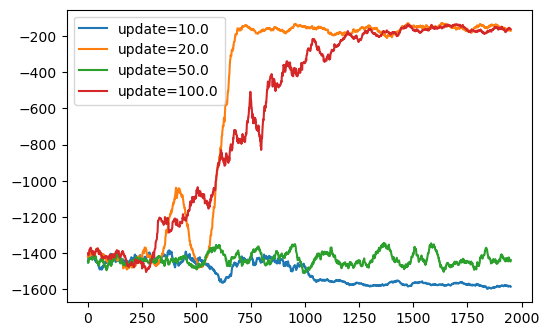

In [12]:
fig=plt.figure(figsize=(6,3.8))
for update,rew in rewards.items():
    plt.plot(running_mean(rew,50),label=f"update={update}")
plt.legend()

### Learning rate dependency

Here done for update_every 20 episodes

In [13]:
rewards = {}
lrs = [0.001, 0.0005, 0.0001, 0.00005]
eps=0.1
ts=32
seed=999

for lr in lrs:
    with open(f"./results/DDPG_{env_name}-eps{eps}-t{ts}-l{lr}-s{seed}-stat.pkl", 'rb') as f:
        data = pickle.load(f)
        rewards[data["lr"]] = data["rewards"]

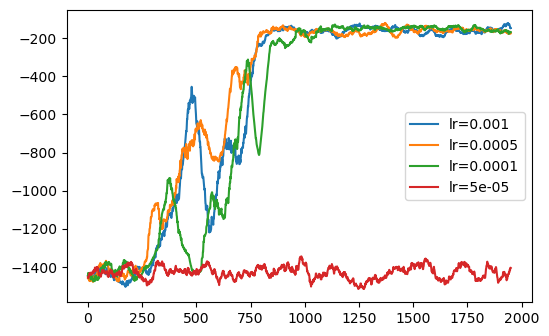

In [14]:
fig=plt.figure(figsize=(6,3.8))
for lr,rew in rewards.items():
    plt.plot(running_mean(rew,50),label=f"lr={lr}")
plt.legend()

## value function

In [15]:
def plot_Q_function(q_function, observations, actions, plot_dim1=0, plot_dim2=2,
                    label_dim1="cos(angle)", label_dim2="angular velocity"):
    plt.rcParams.update({'font.size': 12})
    values =q_function.predict(np.hstack([observations,actions]))
    
    fig = plt.figure(figsize=[10,8])
    ax = fig.add_subplot()
    surf = ax.scatter (observations[:,plot_dim1], observations[:,plot_dim2],  c = values, cmap=cm.coolwarm)
    ax.set_xlabel(label_dim1)
    ax.set_ylabel(label_dim2)

    return fig

In [16]:
env = gym.make(env_name)

In [17]:
episodes=2000
eps=0.1
ts=32
lr=0.0001
checkpoint = f"./results/DDPG_{env_name}_{episodes}-eps{eps}-t{ts}-l{lr}-s1.pth"

In [18]:
agent  = DDPG.DDPGAgent(env.observation_space, env.action_space)
agent.restore_state(torch.load(checkpoint))

In [19]:
observations, actions, rewards = run(env,agent,100, noise=0.2)

Mean reward: -197.9766228459799


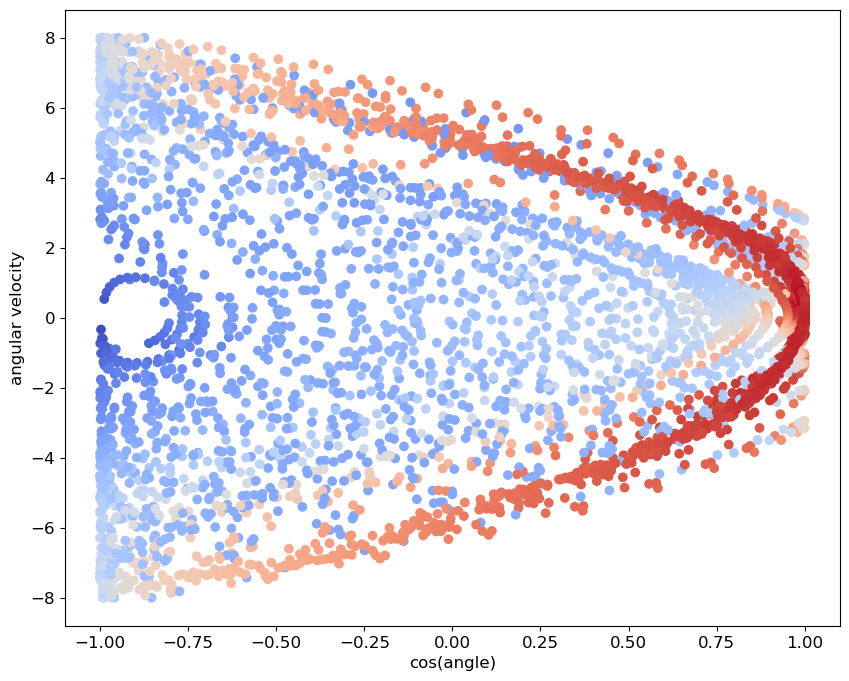

In [20]:
_ = plot_Q_function(agent.Q,observations,actions)

## HalfCheetah

In [21]:
env_name = "HalfCheetah-v4"

eps=0.1
ts=32
lr=0.0001
seed=1

with open(f"./results/DDPG_{env_name}-eps{eps}-t{ts}-l{lr}-s{seed}-stat.pkl", 'rb') as f:
    data = pickle.load(f)
    rewards = np.asarray(data["rewards"])
    losses =  np.asarray(data["losses"])

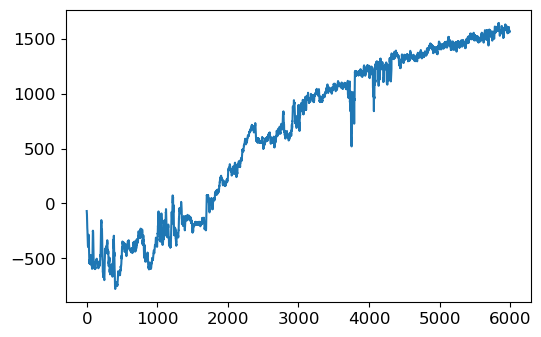

In [22]:
fig=plt.figure(figsize=(6,3.8))
plt.plot(running_mean(rewards,10))

In [23]:
rewards = {}
lr = 0.0001
eps=[0.1,0.3,0.5]
ts=32
seed=1

for e in eps:
    with open(f"./results/DDPG_{env_name}-eps{e}-t{ts}-l{lr}-s{seed}-stat.pkl", 'rb') as f:
        data = pickle.load(f)
        rewards[e] = data["rewards"]

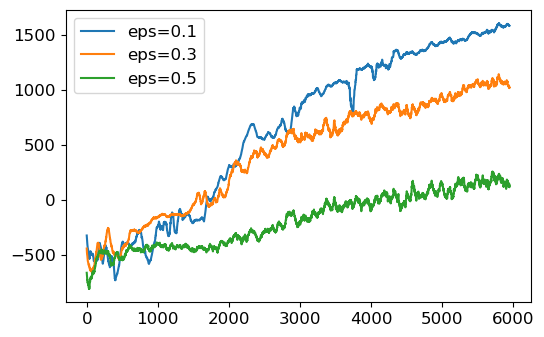

In [24]:
fig=plt.figure(figsize=(6,3.8))
for eps,rew in rewards.items():
    plt.plot(running_mean(rew,50),label=f"eps={eps}")
plt.legend()

In [25]:
fig.savefig(f"DDPG_{env_name}_effect_noise.pdf")

In [26]:
env = gym.make(env_name, render_mode="human")

In [27]:
episodes=6000
eps=0.1
checkpoint = f"./results/DDPG_{env_name}_{episodes}-eps{eps}-t{ts}-l{lr}-s1.pth"

In [28]:
agent  = DDPG.DDPGAgent(env.observation_space, env.action_space)
agent.restore_state(torch.load(checkpoint))

In [ ]:
observations, actions, rewards = run(env,agent,2, noise=0)

: 

: 

In [ ]:
env.close()

## Lunar Lander
The DDPG is not able to solve the Lunar Lander (at least with our implementation and the parameters we tried)

In [56]:
env_name = "LunarLander-v2"

eps=0.1
ts=32
lr=0.0001
s=1

with open(f"./results/DDPG_{env_name}-eps{eps}-t{ts}-l{lr}-s{s}-stat.pkl", 'rb') as f:
    data = pickle.load(f)
    rewards = np.asarray(data["rewards"])
    losses =  np.asarray(data["losses"])

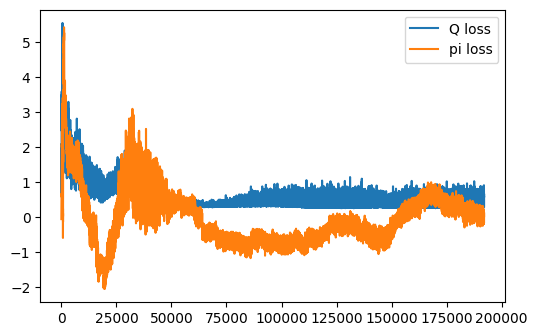

In [57]:
fig=plt.figure(figsize=(6,3.8))
plt.plot(running_mean(losses[:,0],10),label=f"Q loss")
plt.plot(running_mean(losses[:,1],10),label=f"pi loss")
plt.legend()

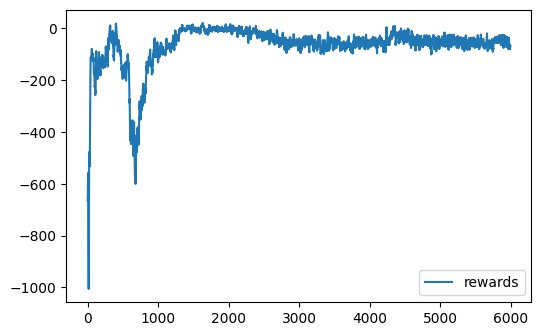

In [58]:
fig=plt.figure(figsize=(6,3.8))
plt.plot(running_mean(rewards,10),label=f"rewards")
plt.legend()

In [59]:
rewards = {}
lr = 0.0001
eps=[0.1,0.3,0.5]
ts=32
seed=1

for e in eps:
    with open(f"./results/DDPG_{env_name}-eps{e}-t{ts}-l{lr}-s{seed}-stat.pkl", 'rb') as f:
        data = pickle.load(f)
        rewards[e] = data["rewards"]

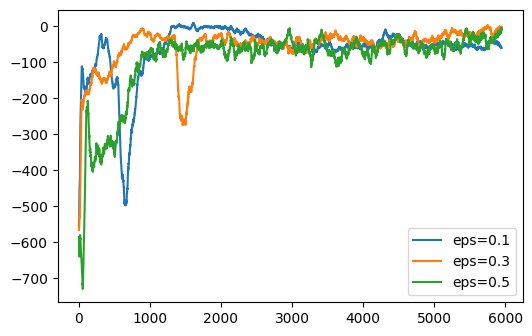

In [60]:
fig=plt.figure(figsize=(6,3.8))
for eps,rew in rewards.items():
    plt.plot(running_mean(rew,50),label=f"eps={eps}")
plt.legend()

In [71]:
env = gym.make(env_name, render_mode="human", continuous=True)

In [72]:
episodes=6000
eps=0.1
checkpoint = f"./results/DDPG_{env_name}_{episodes}-eps{eps}-t{ts}-l{lr}-s1.pth"

In [73]:
agent  = DDPG.DDPGAgent(env.observation_space, env.action_space)
agent.restore_state(torch.load(checkpoint))

In [74]:
observations, actions, rewards = run(env,agent,2, noise=0)

Mean reward: -123.70174114226327


In [99]:
env.close()